![](https://raw.githubusercontent.com/noszitomi/temp_pics/refs/heads/main/qec_banner.png)
# Base functionality
---

#### Library of popular quantum error correction code constructions:
1. general stabilizer codes
2. Calderbank - Steane - Shor (CSS) codes 
3. Hypergraph Prodcut (HGP) codes
4. Surface codes 

#### Tools for the 'fundamental' analysis of the above families:
- physical qubit number
- logical qubit number
- Z and X code distance 
    - exact calculation for smaller codes
    - heuristi method (based on BP-OSD) for large codes 
- Z and X logical operator basis 


> 
> *note*:\
> \
> The deeper you move in the code familiy hierarchy, the more optimal our methods are.\
> E.g.: the distance calucaltion for a HGP code is faster than for a CSS code.
> 

Basic example on the base functionality:

In [8]:
import numpy as np
from qec.code_constructions import CSSCode

hamming_code = np.array([[1, 0, 0, 1, 0, 1, 1],
                         [0, 1, 0, 1, 1, 0, 1],
                         [0, 0, 1, 0, 1, 1, 1]])

steane_code = CSSCode(x_stabilizer_matrix = hamming_code,
                      z_stabilizer_matrix = hamming_code,
                      name = 'Steane')
print(steane_code)

Steane Code: [[N=7, K=1, dx<=None, dz<=None]]


In [2]:
steane_code.compute_exact_code_distance()
print(steane_code)
print('The overall code distance is: ', steane_code.code_distance)
print('The logical operators are: \n',steane_code.logical_operator_basis.toarray())
print('with wieghts: ',steane_code.logical_basis_weights())

Steane Code: [[N=7, K=1, dx<=3, dz<=3]]
The overall code distance is:  3
The logical operators are: 
 [[1 1 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 1 0 0 0]]
with wieghts:  (array([3]), array([3]))


#### How the base functionality can 'kickstart' a QEC researcher's work:
---

![](https://raw.githubusercontent.com/noszitomi/temp_pics/refs/heads/main/kickstart_scenario.png)

They can already do some quick analysis just by finding the narrowest familiy the construction belongs to!
In the above [paper](https://www.nature.com/articles/s41586-024-07107-7) they introduce the so called Bivariate Bycicle codes, that belong to the CSS code familiy. 
Therefore, they can already use the tools that are available thourgh our CSS class:

In [3]:
#------------------------------------------------------------------------------
# Code is taken from the Bivariate Bycicle Codes paper:
# https://github.com/sbravyi/BivariateBicycleCodes/blob/main/distance_test.py
#------------------------------------------------------------------------------

# [[144,12,12]]
ell,m = 12,6
a1,a2,a3 = 3,1,2
b1,b2,b3 = 3,1,2

n = 2*ell*m
n2 = ell*m

# define cyclic shift matrices 
I_ell = np.identity(ell,dtype=int)
I_m = np.identity(m,dtype=int)
I = np.identity(ell*m,dtype=int)
x = {}
y = {}
for i in range(ell):
	x[i] = np.kron(np.roll(I_ell,i,axis=1),I_m)
for i in range(m):
	y[i] = np.kron(I_ell,np.roll(I_m,i,axis=1))
A = (x[a1] + y[a2] + y[a3]) % 2
B = (y[b1] + x[b2] + x[b3]) % 2

hx = np.hstack((A,B))
hz = np.hstack((np.transpose(B),np.transpose(A)))

In [4]:
bivariate_bycycle_code = CSSCode(x_stabilizer_matrix = hx,
                                  z_stabilizer_matrix = hz,
                                  name = 'Bivariate Bycycle')

Here we can also showcase our distance, estimation method. First we try to calculate the exact disdtance (we expect this to fail due to the large number of logical qubits k > 10):

In [5]:
# bivariate_bycycle_code.compute_exact_code_distance() # uncomment to demonstrate crash

Indeed the kernel crashed. It's time to turn to our heuristic method:

In [6]:
bivariate_bycycle_code.estimate_min_distance()
print(bivariate_bycycle_code)


Estimating distance: dx <= 12, dz <= 12, x-weights: 12.00, z-weights: 16.83: 100%|█████████▉| 0.24891376495361328/0.25 [00:00<00:00,  1.16it/s] 

Bivariate Bycycle Code: [[N=144, K=12, dx<=12, dz<=12]]


Not only did the estimation **returned the optimal distance**, the same value that they give in the paper, it was done **in only 0.25 seconds!**

# Circuit compilation 
---

After obtaining the fundamental properties of a new QEC code, one needs to perform circuit-level noise simulations to analyse its fault-tolerant implementation.

Memory experiments, where a logical state is prepared and maintained through repeated error correction rounds to combat decoherence and gate errors that occur over time in real quantum hardware, are the easiest to simulate while providing this insight.

To create such an experiment we rely on the information that can be obtained using the **base functionality** of our package. By accessing the stabilizers and the logical operators of the code we can construct the required circuit:

Hypergraph product code Hypergraphproduct Code: [[N=58, K=16, dx=None, dz=None]]


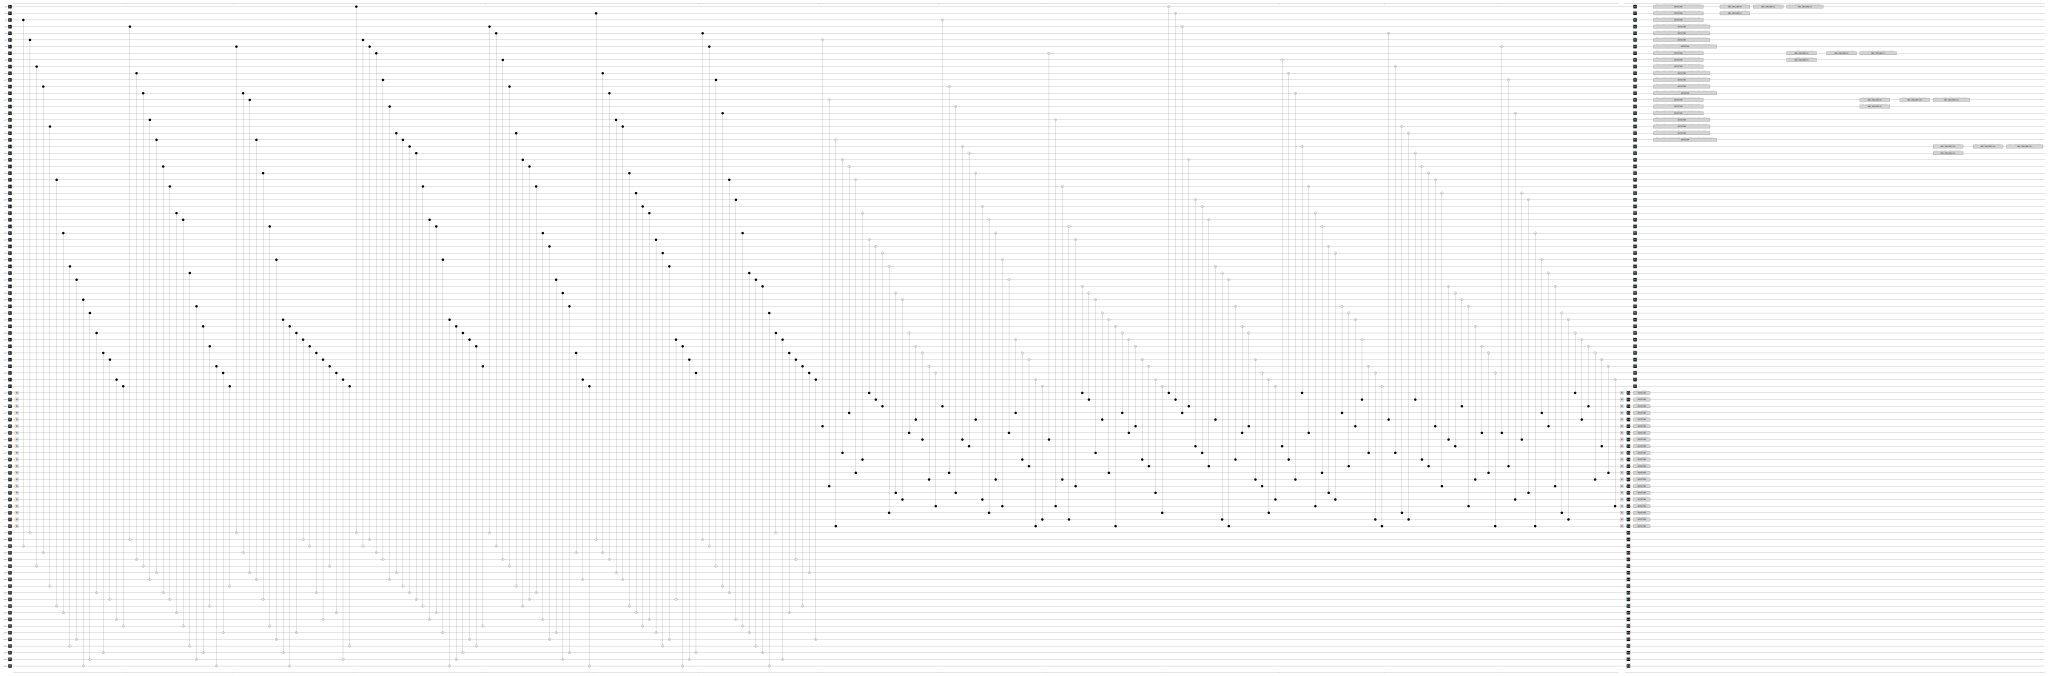

In [12]:
from qec.circuit_compilation import MemoryExperiment
from qec.code_constructions import HypergraphProductCode

example_code = HypergraphProductCode(hamming_code, hamming_code)
print(example_code)

hgp_memory = MemoryExperiment(example_code)
circuit = hgp_memory.circuit(basis = 'X', rounds = 1, noise = False)
circuit.diagram('timeline-svg')

Here we can also showcase our `load_code` functionality: one can simply save code instances, then reload them for further work:

In [11]:
from qec.utils import load_code
previously_saved_hgp_code = load_code('../src/qec/code_instances/saved_codes/1.json')

print(previously_saved_hgp_code)

an_other_memory_experiment = MemoryExperiment(previously_saved_hgp_code)
circuit = an_other_memory_experiment.circuit(basis = 'Z', rounds = 1, noise = False)
circuit.diagram('timeline-svg')

Hypergraph product code Hypergraphproduct Code: [[N=512, K=8, dx=4, dz=4]]


### From circuit to simulation

Finally we showcase how our package can be combined with `stim` to create simulation:

In [ ]:
from qec.code_constructions import SurfaceCode
from qec.circuit_compilation.noise_model import NoiseModel

import stim
import sinter
import multiprocessing
from matplotlib import pyplot as plt

In [14]:
def generate_samples():
    for p in [0.008, 0.009, 0.01, 0.011, 0.012, 0.014]:
        for d in [3, 5, 7]:
            yield sinter.Task(
                circuit = NoiseModel.uniform_depolarizing_noise(p).noisy_circuit(MemoryExperiment(SurfaceCode(dx = d, dz = d)).circuit(basis = 'Z', rounds = 3 * d)),
                json_metadata = {
                    'p': p,
                    'd': d,
                    'r': 3 * d,
                }
            )

def run_experiments():
    samples = sinter.collect(
        num_workers = multiprocessing.cpu_count() - 1,
        max_shots = 1_000_000,
        max_errors = 5_000,
        tasks = generate_samples(),
        decoders = ['pymatching'],
        print_progress = True,
        )
    
    return samples

In [15]:
surface_code_data = run_experiments()

Starting 7 workers...
18 tasks left:
  workers    decoder eta shots_left errors_left json_metadata   
        1 pymatching <1m     995631        4625 p=0.008,d=3,r=9 
        1 pymatching   ?    1000000        5000 p=0.008,d=5,r=15
        1 pymatching   ?    1000000        5000 p=0.008,d=7,r=21
        1 pymatching   ?    1000000        5000 p=0.009,d=3,r=9 
        1 pymatching   ?    1000000        5000 p=0.009,d=5,r=15
        1 pymatching   ?    1000000        5000 p=0.009,d=7,r=21
        1 pymatching   ?    1000000        5000 p=0.01,d=3,r=9  
        0 pymatching ?·∞    1000000        5000 p=0.01,d=5,r=15 
        0 pymatching ?·∞    1000000        5000 p=0.01,d=7,r=21 
        0 pymatching ?·∞    1000000        5000 p=0.011,d=3,r=9 
        0 pymatching ?·∞    1000000        5000 p=0.011,d=5,r=15
        0 pymatching ?·∞    1000000        5000 p=0.011,d=7,r=21
        0 pymatching ?·∞    1000000        5000 p=0.012,d=3,r=9 
        0 pymatching ?·∞    1000000        5000 p=0.0

In [22]:
import logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

DEBUG:matplotlib.ticker:vmin 0.004062764471177548 vmax 0.04869877737328621
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])
DEBUG:matplotlib.ticker:vmin 0.004062764471177548 vmax 0.04869877737328621
DEBUG:matplotlib.ticker:ticklocs array([2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00])
DEBUG:matplotlib.ticker:vmin 0.004062764471177548 vmax 0.04869877737328621
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])
DEBUG:matplotlib.ticker:vmin 0.004062764471177548 vmax 0.04869877737328621
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])
DEBUG:matplotlib.ticker:vmin 0.004062764471177548 vmax 0.04869877737

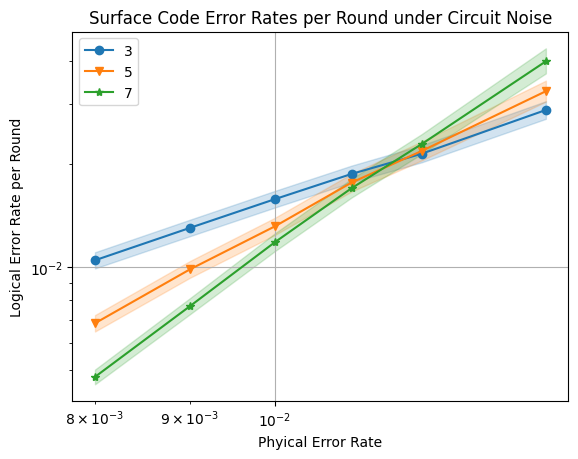

In [23]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=surface_code_data,
    x_func=lambda stat: stat.json_metadata['p'],
    group_func=lambda stat: stat.json_metadata['d'],
    failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
)

ax.set_title("Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.loglog()
ax.grid(which='major')
ax.legend() 
plt.show()

DEBUG:matplotlib.ticker:vmin 6.30957344480193e-08 vmax 0.001584893192461114


DEBUG:matplotlib.ticker:ticklocs array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01])
DEBUG:matplotlib.ticker:vmin 6.30957344480193e-08 vmax 0.001584893192461114
DEBUG:matplotlib.ticker:ticklocs array([2.e-09, 3.e-09, 4.e-09, 5.e-09, 6.e-09, 7.e-09, 8.e-09, 9.e-09,
       2.e-08, 3.e-08, 4.e-08, 5.e-08, 6.e-08, 7.e-08, 8.e-08, 9.e-08,
       2.e-07, 3.e-07, 4.e-07, 5.e-07, 6.e-07, 7.e-07, 8.e-07, 9.e-07,
       2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06, 9.e-06,
       2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01])
DEBUG:matplotlib.ticker:vmin 6.30957344480193e-08 vmax 0.001584893192461114
DEBUG:matplotlib.ticker:ticklocs array([1.e-09, 1.e-08,

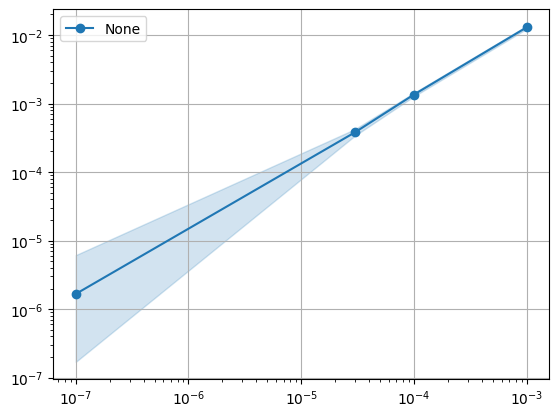

In [44]:
def costum_colors(stat):

    if stat == 12:
        return {'color' : '#26476D'} # dark blue
    if stat == 5:
        return {'color' : '#82B5EE'} # light blue
    if stat == 7:
        return {'color' : '#18C46B'} # light green
  

fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=big_experiment,
    x_func=lambda stat: stat.json_metadata['p'],
    # group_func=lambda stat: stat.json_metadata['d'],
    failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
    # plot_args_func = lambda r, stat: costum_colors(stat)
)

# ax.set_ylim(5e-3, 5e-2)
# ax.set_xlim(0.008, 0.012)
ax.loglog()
# ax.set_title("Surface Code Error Rates per Round under Circuit Noise")
# ax.set_xlabel("Phyical Error Rate")
# ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
# ax.grid(which='minor')
ax.legend()

In [23]:
def generate_samples():
    for p in [0.008, 0.009, 0.01, 0.011, 0.012, 0.014]:
        for d in [3, 5, 7]:
            yield sinter.Task(
                circuit = NoiseModel.uniform_depolarizing_noise(p).noisy_circuit(MemoryExperiment(SurfaceCode(dx = d, dz = d)).circuit(basis = 'Z', rounds = 3 * d)),
                json_metadata = {
                    'p': p,
                    'd': d,
                    'r': 3 * d,
                }
            )

def run_experiments():
    samples = sinter.collect(
        num_workers = multiprocessing.cpu_count() - 1,
        max_shots = 1_000_000,
        max_errors = 5_000,
        tasks = generate_samples(),
        decoders = ['pymatching'],
        # custom_decoders= {'bposd' : SinterBpOsdDecoder(
        #         max_iter = 13,
        #         bp_method = 'ms',
        #         ms_scaling_factor = 0.5,
        #         schedule = "parallel",
        #         osd_method = 'osd0')},
        print_progress = True,

            )
    
    return samples

In [ ]:
def costum_colors(stat):
    if stat == 3: #<--- these numbers are matching the r values below
        return {'color' : '#26476D'} # dark blue
    if stat == 5:
        return {'color' : '#82B5EE'} # light blue
    if stat == 7:
        return {'color' : '#18C46B'} # light green
  

def generate_samples():
    for p in [0.008, 0.009, 0.01, 0.011, 0.012, 0.014]:
        for d in [3, 5, 7]:
            yield sinter.Task(
                circuit = NoiseModel.uniform_depolarizing_noise(p).noisy_circuit(MemoryExperiment(SurfaceCode(dx = d, dz = d)).circuit(basis = 'Z', rounds = 3 * d)),
                json_metadata = {
                    'p': p,
                    'd': d,
                    'r': 3 * d, # <--- these numbers are matching the stat values above
                })

fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=generated_samples,
    x_func=lambda stat: stat.json_metadata['p'],
    group_func=lambda stat: stat.json_metadata['d'],
    failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
    plot_args_func = lambda r, stat: costum_colors(stat) # <--- here after the lambda I set r as the input for the costum_colors 
                                                         #      if you want to color according to a different variable change r to it.
)

ax.loglog()
ax.grid(which='major')
ax.legend() # <--- if only one line, maybe turn it off

plt.savefig('surface_code_experiment.png', dpi=300)

Starting 7 workers...
18 tasks left:
  workers    decoder eta shots_left errors_left json_metadata   
        1 pymatching <1m     996655        4709 p=0.008,d=3,r=9 
        1 pymatching   ?    1000000        5000 p=0.008,d=5,r=15
        1 pymatching   ?    1000000        5000 p=0.008,d=7,r=21
        1 pymatching   ?    1000000        5000 p=0.009,d=3,r=9 
        1 pymatching   ?    1000000        5000 p=0.009,d=5,r=15
        1 pymatching   ?    1000000        5000 p=0.009,d=7,r=21
        1 pymatching   ?    1000000        5000 p=0.01,d=3,r=9  
        0 pymatching ?·∞    1000000        5000 p=0.01,d=5,r=15 
        0 pymatching ?·∞    1000000        5000 p=0.01,d=7,r=21 
        0 pymatching ?·∞    1000000        5000 p=0.011,d=3,r=9 
        0 pymatching ?·∞    1000000        5000 p=0.011,d=5,r=15
        0 pymatching ?·∞    1000000        5000 p=0.011,d=7,r=21
        0 pymatching ?·∞    1000000        5000 p=0.012,d=3,r=9 
        0 pymatching ?·∞    1000000        5000 p=0.0

DEBUG:matplotlib.ticker:vmin 0.00777925637718221 vmax 0.014397262999136235
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])
DEBUG:matplotlib.ticker:vmin 0.00777925637718221 vmax 0.014397262999136235
DEBUG:matplotlib.ticker:ticklocs array([2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00])
DEBUG:matplotlib.ticker:vmin 0.00777925637718221 vmax 0.014397262999136235
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])
DEBUG:matplotlib.ticker:vmin 0.00777925637718221 vmax 0.014397262999136235
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])
DEBUG:matplotlib.ticker:vmin 0.00777925637718221 vmax 0.014397262999

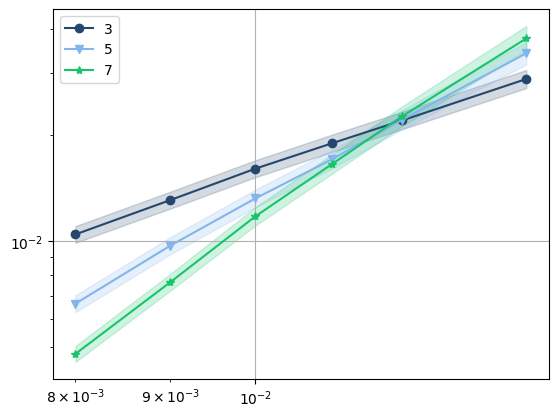

In [25]:
plsplspls_work = run_experiments()



DEBUG:matplotlib.ticker:vmin 0.008 vmax 0.014
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])
DEBUG:matplotlib.ticker:vmin 0.008 vmax 0.014
DEBUG:matplotlib.ticker:ticklocs array([2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00])
DEBUG:matplotlib.ticker:vmin 0.008 vmax 0.014
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])
DEBUG:matplotlib.ticker:vmin 0.008 vmax 0.014
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])
DEBUG:matplotlib.ticker:vmin 0.008 vmax 0.014
DEBUG:matplotlib.ticker:ticklocs array([2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e

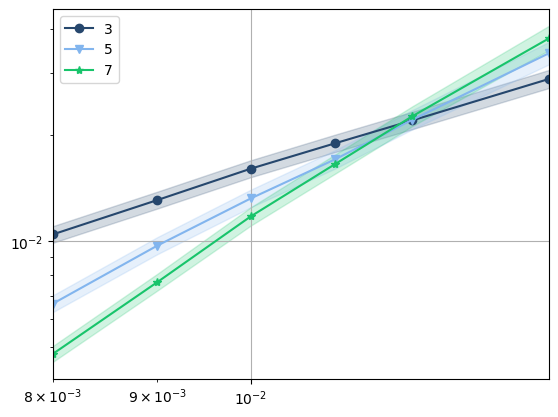

In [27]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=plsplspls_work,
    x_func=lambda stat: stat.json_metadata['p'],
    group_func=lambda stat: stat.json_metadata['d'],
    failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
    plot_args_func = lambda r, stat: costum_colors(stat)
)

# ax.set_ylim(5e-3, 5e-2)
ax.set_xlim(0.008, 0.014)
ax.loglog()
# ax.set_title("Surface Code Error Rates per Round under Circuit Noise")
# ax.set_xlabel("Phyical Error Rate")
# ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
# ax.grid(which='minor')
ax.legend()

plt.savefig('surface_code_experiment.png', dpi=300)

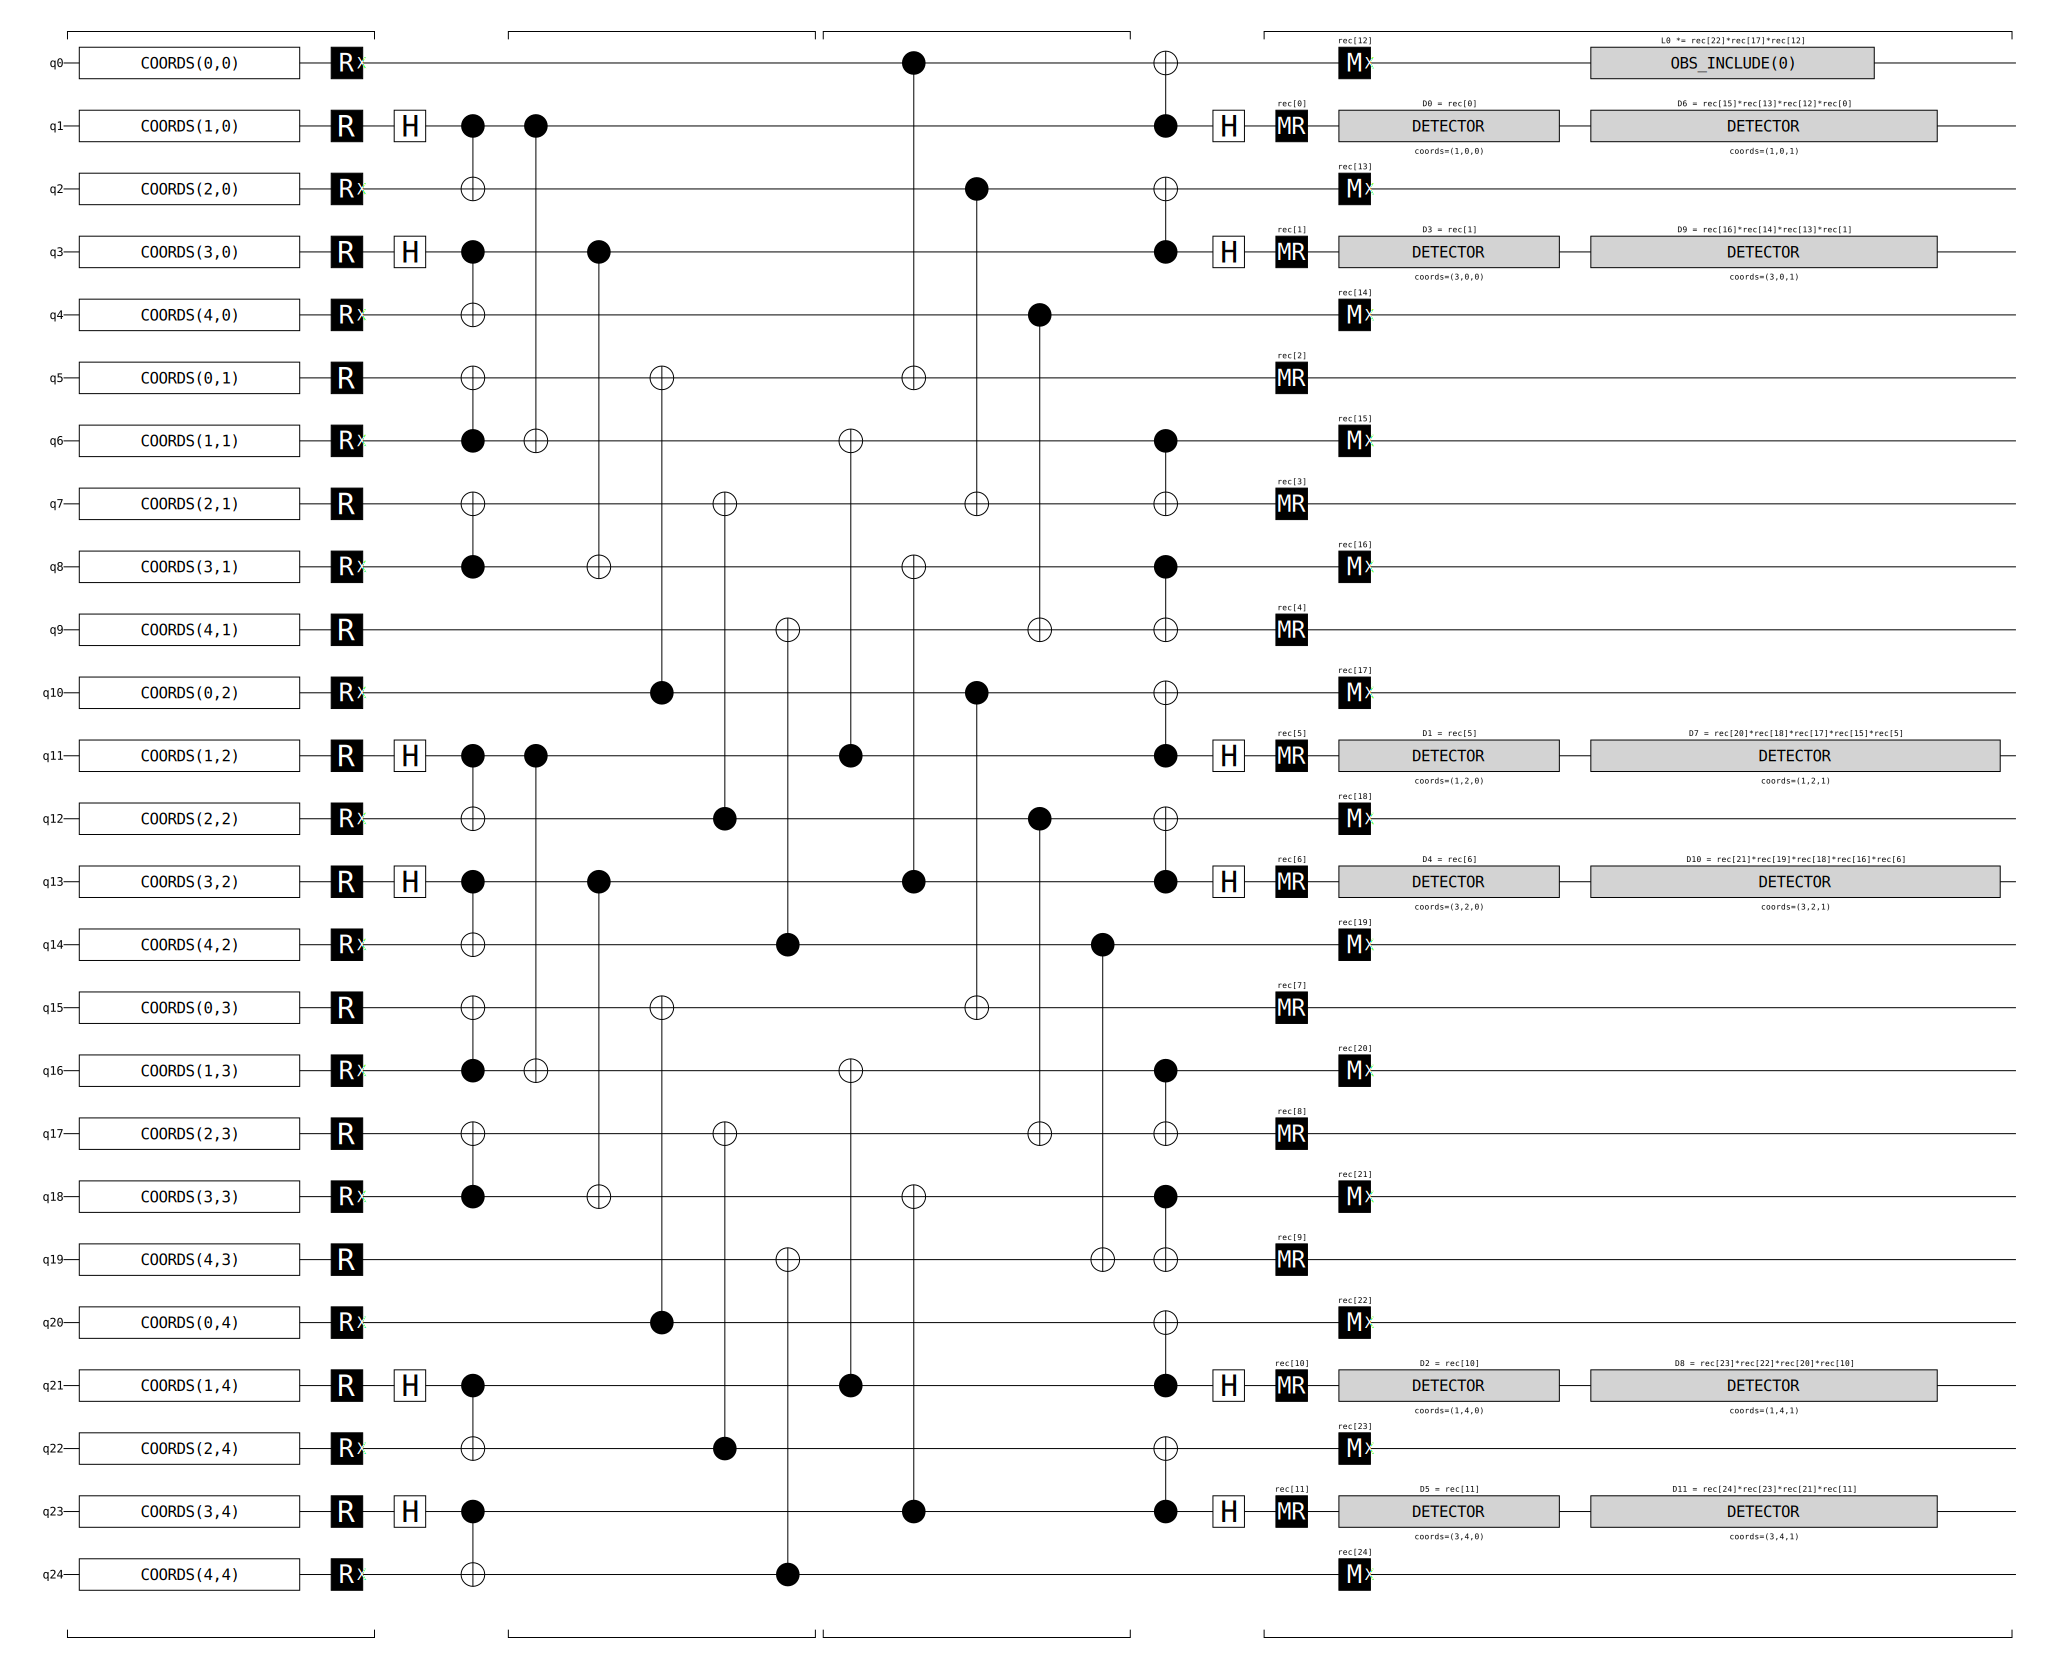

In [30]:

circuit = stim.Circuit.generated(
            "surface_code:unrotated_memory_x",
            rounds=1,
            distance=3)
            # after_clifford_depolarization=noise,
            # after_reset_flip_probability=noise,
            # before_measure_flip_probability=noise,
            # before_round_data_depolarization=noise)

circuit.diagram('timeline-svg')

---

For preview: `pip install qec`

*Authors: Joschka Roffe, Tamas Noszko, Liam Veeder-Sweeny*

